In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2DTranspose, Conv2D, Input, BatchNormalization, Activation, concatenate
)
import os
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import directed_hausdorff
import imageio

import matplotlib.pyplot as plt

In [2]:
path = ''
image_path = os.path.join(path, 'data/images/')
mask_path = os.path.join(path, 'data/panoptic/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig if i.endswith('.jpg')][:2000]
mask_list = [os.path.join(mask_path, i) for i in mask_list_orig if i.endswith('.png')][:2000]

test_image_path = os.path.join(path, 'val_cityscapes/img/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig if i.endswith('.png')]


In [3]:
def process_test_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128))
    return img

# Preprocess testing data
test_image_filenames = tf.constant(test_image_list)

# Convert to TensorFlow Dataset
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_filenames)

# Apply preprocessing function to the dataset
test_image_ds = test_image_ds.map(process_test_path)


C:\Users\Tanma\AppData\Local\Temp\ipykernel_7376\1645610153.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Tanma\AppData\Local\Temp\ipykernel_7376\1645610153.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

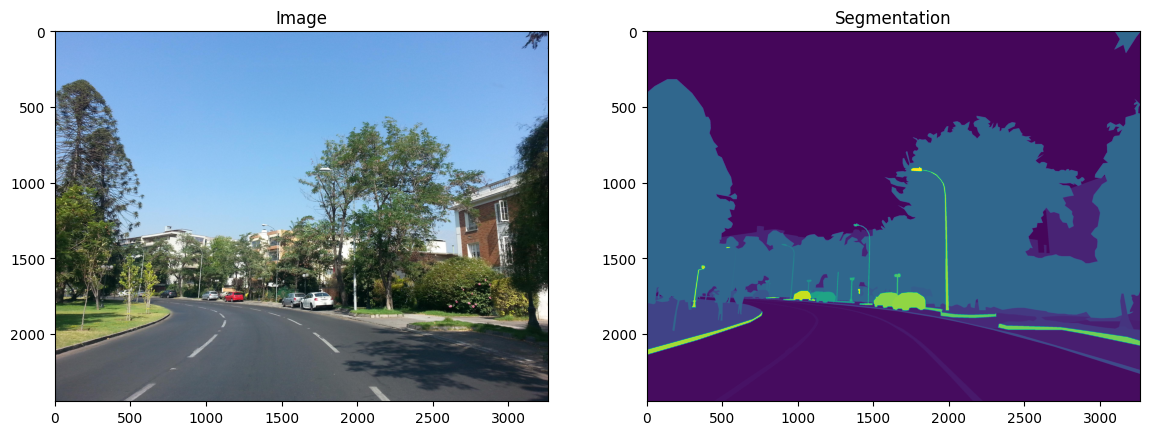

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--NSVcUgfVhFd6uzkqHOOg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--NSVcUgfVhFd6uzkqHOOg.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--SWG8TJo7vrbZ_x5YLj6A.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--SWG8TJo7vrbZ_x5YLj6A.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--WOpVBuHlCygAUADkttpg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--WOpVBuHlCygAUADkttpg.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

test_filenames = tf.constant(test_image_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))


for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/images/--jRsD9anHdGxv4ZOCQktA.jpg', shape=(), dtype=string)
tf.Tensor(b'data/panoptic/--jRsD9anHdGxv4ZOCQktA.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
num_classes = 124
def preprocess_labels(dataset, num_classes):
    def map_labels(image, label):
        label = tf.clip_by_value(label, 0, num_classes - 1)  # Clip to valid range
        return image, label
    return dataset.map(map_labels)

processed_image_ds = preprocess_labels(processed_image_ds, num_classes)

In [8]:
def build_alexnet_segmentation(input_shape=(96, 128, 3), num_classes=124):
    """
    Build a semantic segmentation model using AlexNet-like architecture as the encoder.

    Args:
        input_shape: Tuple, the shape of the input image.
        num_classes: Integer, the number of segmentation classes.

    Returns:
        A TensorFlow Keras Model for segmentation.
    """
    inputs = Input(shape=input_shape)

    # Encoder (AlexNet-like)
    x = Conv2D(96, (11, 11), strides=4, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((3, 3), strides=2, padding="same")(x)

    x = Conv2D(256, (5, 5), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((3, 3), strides=2, padding="same")(x)

    x = Conv2D(384, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(384, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    encoder_output = MaxPooling2D((3, 3), strides=2, padding="same")(x)

    print(f"Encoder output shape: {encoder_output.shape}")  # Debugging output shape

    # Decoder
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(encoder_output)  # Upsample to 1/8
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After first Conv2DTranspose: {x.shape}")  # Debugging output shape

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)  # Upsample to 1/4
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After second Conv2DTranspose: {x.shape}")  # Debugging output shape

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)  # Upsample to 1/2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After third Conv2DTranspose: {x.shape}")  # Debugging output shape

    x = Conv2DTranspose(32, (3, 3), strides=(4, 2), padding="same")(x)  # Upsample to match width
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After fourth Conv2DTranspose: {x.shape}")  # Debugging output shape

    # Final upsampling to original image size (48, 128)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 2), padding="same")(x)  # Adjust height to match 48
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    print(f"After final Conv2DTranspose: {x.shape}")  # Debugging output shape

    # Output layer for segmentation mask
    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(x)  # Use softmax for multi-class
    print(f"Output layer shape: {outputs.shape}")  # Debugging output shape

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [9]:
input_shape = (96, 128, 3)
num_classes = 124
model = build_alexnet_segmentation(input_shape=input_shape, num_classes=num_classes)

Encoder output shape: (None, 3, 4, 256)
After first Conv2DTranspose: (None, 6, 8, 256)
After second Conv2DTranspose: (None, 12, 16, 128)
After third Conv2DTranspose: (None, 24, 32, 64)
After fourth Conv2DTranspose: (None, 96, 64, 32)
After final Conv2DTranspose: (None, 96, 128, 32)
Output layer shape: (None, 96, 128, 124)


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 24, 32, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 32, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 24, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 16, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 12, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 6, 8, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 8, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 8, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 6, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 6, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 4, 256)           │              

 Total params: 4,745,468 (18.10 MB)

 Trainable params: 4,741,692 (18.09 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [12]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Cast y_true to the same data type as y_pred_labels
    y_true = tf.cast(y_true, y_pred_labels.dtype)
    # Compare predicted labels to true labels and compute accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    return accuracy




def mean_iou(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Compute IoU for each class
    iou = []
    for i in range(1, 66):  # Excluding background class 0
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        iou.append((intersection + 1e-7) / (union + 1e-7))  # Add small epsilon to avoid division by zero
    # Compute mean IoU across classes
    mean_iou = tf.reduce_mean(iou)
    return mean_iou

def dice_coefficient(y_true, y_pred, smooth=1e-4):
    """
    Compute the Dice Similarity Coefficient for multi-class segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits or probabilities, shape (batch_size, height, width, num_classes).
        smooth: Smoothing factor to avoid division by zero.

    Returns:
        Dice coefficient as a scalar between 0 and 1.
    """
    # Convert ground truth to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])  # [?, 96, 128, 66]
    y_true_one_hot = tf.squeeze(y_true_one_hot, axis=-2)  # Remove the extra dimension if it exists

    # Apply softmax to predicted logits
    y_pred = tf.nn.softmax(y_pred)

    # Compute intersection and union for each class
    intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true_one_hot, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

    # Compute Dice coefficient for each class and average
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)




def hausdorff_distance_np(y_true, y_pred):
    """
    Compute the Hausdorff Distance between two binary masks using NumPy and SciPy.

    Args:
        y_true: Ground truth binary mask, shape (height, width).
        y_pred: Predicted binary mask, shape (height, width).

    Returns:
        Hausdorff Distance as a scalar.
    """
    y_true = np.asarray(y_true > 0.5, dtype=bool)
    y_pred = np.asarray(y_pred > 0.5, dtype=bool)

    true_points = np.argwhere(y_true)
    pred_points = np.argwhere(y_pred)

    forward_distance = directed_hausdorff(true_points, pred_points)[0]
    backward_distance = directed_hausdorff(pred_points, true_points)[0]

    return max(forward_distance, backward_distance)

def tf_hausdorff_distance(y_true, y_pred):
    """
    TensorFlow wrapper for Hausdorff Distance.

    Args:
        y_true: Ground truth binary mask, shape (batch_size, height, width, channels).
        y_pred: Predicted binary mask, shape (batch_size, height, width, channels).

    Returns:
        Hausdorff Distance as a scalar tensor.
    """
    def compute_np_hausdorff(y_true_np, y_pred_np):
        return np.array([hausdorff_distance_np(y_true_np[i], y_pred_np[i]) for i in range(len(y_true_np))])

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    results = tf.py_function(
        func=compute_np_hausdorff,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return tf.reduce_mean(results)


def precision(y_true, y_pred):
    """
    Compute Precision for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Precision as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # Convert logits to class labels
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)  # Shape (batch_size, height, width)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    # Exclude background class (0)
    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    predicted_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_pred_labels, 0), tf.float32))
    
    return true_positive / (predicted_positive + 1e-7)  # Avoid division by zero

def recall(y_true, y_pred):
    """
    Compute Recall.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Recall as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    actual_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))  # Exclude background
    return true_positive / (actual_positive + 1e-7)  # Avoid division by zero


def f1_score(y_true, y_pred):
    """
    Compute F1 Score for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        F1 Score as a scalar.
    """
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-7)


# ,tf_hausdorff_distance,dice_coefficient,mean_iou,pixel_accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[mean_iou,pixel_accuracy,precision])

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(3024, 4032, 1)


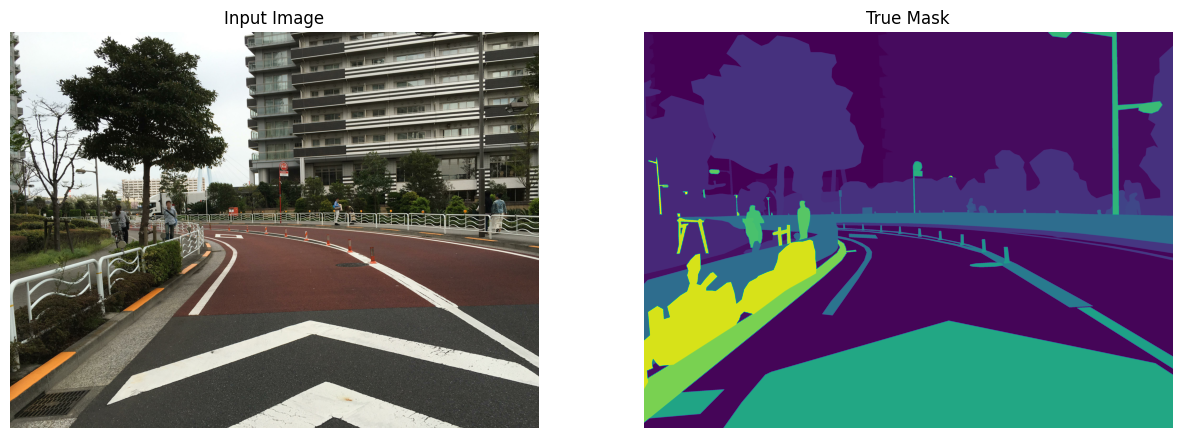

In [14]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


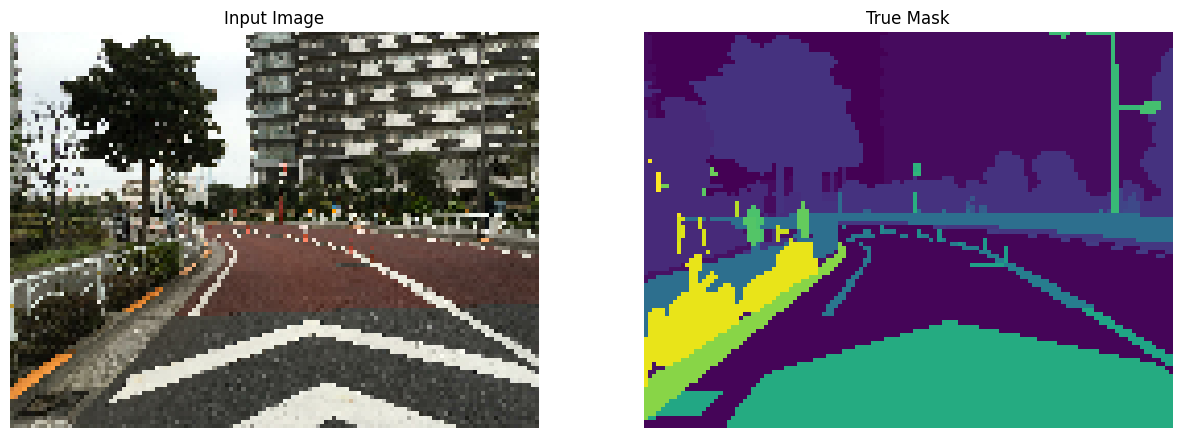

In [15]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [16]:
EPOCHS =150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 4
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150


C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 171ms/step - loss: 3.7589 - mean_iou: 0.0175 - pixel_accuracy: 0.2806 - precision: 0.2806
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 61s 121ms/step - loss: 2.9678 - mean_iou: 0.0239 - pixel_accuracy: 0.3704 - precision: 0.3704
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 124ms/step - loss: 2.9101 - mean_iou: 0.0252 - pixel_accuracy: 0.3820 - precision: 0.3820
Epoch 4/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - loss: 2.9100 - mean_iou: 0.0257 - pixel_accuracy: 0.3725 - precision: 0.3725
Epoch 5/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step - loss: 2.9011 - mean_iou: 0.0262 - pixel_accuracy: 0.3780 - precision: 0.3780
Epoch 6/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - loss: 2.8819 - mean_iou: 0.0260 - pixel_accuracy: 0.3787 - precision: 0.3787
Epoch 7/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 123ms/step - loss: 2.8762 - mean_iou: 0.0269 - pixel_accuracy: 0.3790 - precision: 0.3790
Epoch 8/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step - loss: 2.

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [2]:
# show_predictions(train_dataset, 6)

In [ ]:
def preprocess_test(image):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    return input_image

In [1]:

# import os
# import cv2  # Assuming you're using OpenCV to load images
# import numpy as np
# import tensorflow as tf

# # Assuming test_masks_folder contains the ground truth masks
# test_masks_folder = "test_masks"

# # Load ground truth masks
# true_masks = []
# for image_path in test_image_list:
#     mask_path = os.path.join(test_masks_folder, os.path.basename(image_path))
#     true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     true_masks.append(true_mask)

# # Make predictions using the trained model
# pred_masks = []
# for test_image in test_image_ds.take(len(test_image_list)):
#     test_image = test_image[tf.newaxis, ...]
#     pred_mask = model.predict(test_image)
#     pred_masks.append(pred_mask)

# def create_rgb_mask(mask):
#     """
#     Converts a single-channel mask to a three-channel RGB mask
#     """
#     return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# def convert_mask_color(mask, color_scheme):
#     """
#     Converts a mask's color scheme according to the given color_scheme dictionary
#     """
#     converted_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty RGB mask
#     for value in color_scheme:
#         converted_mask[mask == value] = color_scheme[value]
#     return converted_mask

# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# def show_test_predictions(test_images_preprocessed, pred_masks, true_masks, num=1):
#     """
#     Displays the first num images of the test set along with predicted and ground truth masks
#     """
#     cmap = plt.cm.viridis  # Use the 'viridis' colormap

#     for i, (test_image, pred_mask, true_mask) in enumerate(zip(test_images_preprocessed, pred_masks, true_masks)):
#         if i >= num:
#             break
        
#         display_list = [test_image, create_mask(pred_mask), true_mask]
#         title = ['Test Image', 'Predicted Mask', 'True Mask']
#         display(display_list, title, cmap)

# def display(display_list, title=None, cmap=None):
#     """
#     Displays a list of images with their corresponding titles
#     """
#     plt.figure(figsize=(15, 15))
#     for i in range(len(display_list)):
#         plt.subplot(1, len(display_list), i+1)
#         plt.title(title[i])
#         if cmap is not None and i == len(display_list) - 1:  # Apply colormap only to the last image
#             plt.imshow(display_list[i], cmap=cmap)
#         else:
#             plt.imshow(display_list[i])
#         plt.axis('off')
#     plt.show()

# # Display predictions for the test set along with ground truth
# show_test_predictions(test_image_ds, pred_masks, true_masks, num=17)

